# 終点誤差分散最小モデル
HarrisおよびWolpertは制御信号の大きさに従い，ノイズが生じるモデルを提案した．さらにこのモデルにおいて，状態の分散が可能な限り小さくなるような制御信号を求めた．これを**終点誤差分散最小モデル** (minimum-variance model; {cite:p}`Harris1998-gj`)と呼ぶ．

終点誤差分散最小モデルは状態$\mathbf{x}_t\in \mathbb{R}^n$, 制御信号$\mathbf{u}_t \in \mathbb{R}^p$とし，$\mathbf{A}\in \mathbb{R}^{n\times n}$, $\mathbf{B}\in \mathbb{R}^{n \times p}$とすると，

$$
\begin{equation}
\mathbf{x}_{t+1} = \mathbf{A} \mathbf{x}_t + \mathbf{B}\mathbf{u}_t (1+\boldsymbol{\xi}_t)
\end{equation}
$$

と表せる．ただし，$\boldsymbol{\xi}_t \sim \mathcal{N}(0, k\mathbf{I})\ (k>0)$ である．このため，$\mathbf{u}_t (1+\xi_t)$ の平均は $\mathbf{u}_t$, 分散共分散行列は $k\mathbf{u}_t \mathbf{u}_t^\top$ となる．$\mathbf{x}_t$ を過去の状態 $\mathbf{x}_{t'}\ (t'=0, \ldots, t-1)$ で表すと，

$$
\begin{align}
\mathbf{x}_{t} &= \mathbf{A} \mathbf{x}_{t-1} + \mathbf{B}\mathbf{u}_{t-1} (1+\boldsymbol{\xi}_{t-1})\\
&=\mathbf{A}^2 \mathbf{x}_{t-2} + \mathbf{A}\mathbf{B}\mathbf{u}_{t-2} (1+\boldsymbol{\xi}_{t-2}) + \mathbf{B}\mathbf{u}_{t-1} (1+\boldsymbol{\xi}_{t-1})\\
&=\cdots\\
&=\mathbf{A}^{t} \mathbf{x}_{0} + \sum_{t'=0}^{t-1} \mathbf{A}^{t-t'-1}\mathbf{B}\mathbf{u}_{t'} (1+\boldsymbol{\xi}_{t'})\\
\end{align}
$$

となるので，$\mathbf{x}_t$ の平均と分散共分散行列はそれぞれ，

$$
\begin{align}
\mathbb{E}\left[\mathbf{x}_{t}\right]&=\mathbf{A}^{t} \mathbf{x}_{0}+\sum_{t'=0}^{t-1} \mathbf{A}^{t-t'-1} \mathbf{B} \mathbf{u}_{t'}\\
\operatorname{Cov}\left[\mathbf{x}_{t}\right]&=k\sum_{t'=0}^{t-1}\left(\mathbf{A}^{t-t'-1} \mathbf{B}\right) \mathbf{u}_{t'} \mathbf{u}_{t'}^\top \left(\mathbf{A}^{t-t'-1} \mathbf{B}\right)^{\top}
\end{align}
$$

となる．制御信号の時系列 $\{\mathbf{u}_t\}$ が与えられている場合，状態 $\mathbf{x}_t$ の平均と分散共分散行列は，$\mathbb{E}\left[\mathbf{x}_{0}\right]=\mathbf{x}_0, \operatorname{Cov}\left[\mathbf{x}_{0}\right]=\mathbf{0}\in\mathbb{R}^{n\times n}$ として，

$$
\begin{align}
\mathbb{E}\left[\mathbf{x}_{t}\right] &=\mathbf{A}\mathbb{E}\left[\mathbf{x}_{t-1}\right] + \mathbf{B} \mathbf{u}_{t-1}\\
\operatorname{Cov}\left[\mathbf{x}_{t}\right]&=\mathbf{A}\operatorname{Cov}\left[\mathbf{x}_{t-1}\right]\mathbf{A}^\top + k\mathbf{B} \mathbf{u}_{t-1} \mathbf{u}_{t-1}^\top \mathbf{B}^\top
\end{align}
$$

と逐次的に計算が可能である．

このようなモデルにおいて，次の条件を満たす制御信号を求めることを考える．まず，初期状態を$\mathbf{x}_0$, 目標状態を $\mathbf{x}_f$ とする．また，運動時間を $T_m$, 運動後時間 (post-movement time) を $T_p$ とする．よって1試行にかかる時間は$T:=T_m + T_p$となる．以下では時間は離散化されており，$T_m, T_p, T$ は自然数を取るとする．運動後の停留期間である時刻 $T_m\leq t \leq T$ において，状態の平均が目標状態と一致する，すなわち

$$
\mathbb{E}\left[\mathbf{x}_{t}\right] = \mathbf{x}_f\quad (T_m\leq t \leq T)
$$

を満たし，位置の分散

$$
\mathcal{F}=\sum_{i\in \mathrm{Pos.}}\left[\sum_{t=T_m}^{T} \operatorname{Cov}\left[\mathbf{x}_{t}\right]\right]_{i, i}
$$

を最小にするような制御信号 $\mathbf{u}_t$ を求める．ただし，$\mathrm{Pos.}$ は状態 $\mathbf{x}_t$ の中で位置を表す次元の番号 (インデックス) の集合を意味し，$[\cdot]_{i,i}$は行列の$(i,i)$成分を取り出す操作を意味する．この最適化問題を（躍度最小モデルの際にも用いた）等式制約下の二次計画問題で解くことを考える．二次計画問題で解くには，最小化する目的関数と等式制約をそれぞれ

$$
\begin{align}
&{\text{目的関数}}\quad {\frac {1}{2}}\mathbf{u}^\top \mathbf{P}\mathbf{u} +\mathbf{q} ^{\top}\mathbf{u}\\
&{\text{等式制約}}\quad \mathbf{C}\mathbf{u} =\mathbf{d}
\end{align}
$$

の形にする必要がある．ただし，$\mathbf{P}, \mathbf{C}$は行列，$\mathbf{q}, \mathbf{d}$ はベクトルである．簡単のため，$p=1$ の場合を考慮すると，$\mathbf{u}_t \to u_{t} \in \mathbb{R}$ となる．状態信号の時系列をベクトル化し，$\mathbf{u}=[u_t]_{t=0, \ldots, T-1} \in \mathbf{R}^{T}$ とする．また，後の結果に影響しないため，$k=1$ とする．さらに位置のインデックスを$\mathrm{Pos.}=\{1\}$のみとする．この条件の下，式変形を行うと，目的関数 $\mathcal{F}$ は

$$
\begin{align}
\mathcal{F}=\left[\sum_{t=T_m}^{T} \operatorname{Cov}\left[\mathbf{x}_{t}\right]\right]_{1,1}
&=\left[\sum_{t=T_m}^{T}\sum_{t'=0}^{t-1}u_{t'}^2\left(\mathbf{A}^{t-t'-1} \mathbf{B}\right) \left(\mathbf{A}^{t-t'-1} \mathbf{B}\right)^{\top}\right]_{1,1}\\
&=\sum_{t'=0}^{T-1} u_{t'}^2 \sum_{t=\max(t'+1, T_m)}^{T} \left[\left(\mathbf{A}^{t-t'-1} \mathbf{B}\right)\left(\mathbf{A}^{t-t'-1} \mathbf{B}\right)^{\top} \right]_{1,1}
\end{align}
$$

と書ける．最後の式変形は $u_{t'}^2$ を二重総和の外に出すために行った．この操作は次の図における横方向と縦方向の和の順番を交換することに該当する．

<img src="../_static/images/minimum_variance.png" style="width: 300px;"/>

ここで $V_{t'}:=\sum_{t=\max(t'+1, T_m)}^{T} \left[\left(\mathbf{A}^{t-t'-1} \mathbf{B}\right)\left(\mathbf{A}^{t-t'-1} \mathbf{B}\right)^{\top} \right]_{1,1}$ とすると，$\mathbf{P}=\mathrm{diag}(V_0, \ldots, V_{T-1})\in \mathbf{R}^{T\times T}$ および $\mathbf{q}=\mathbf{0} \in \mathbf{R}^{T}$ と置くことで，$\mathcal{F}=\mathbf{u}^\top \mathbf{P}\mathbf{u}+\mathbf{q} ^{\top}\mathbf{u}$ と書ける．この場合，第2項は0であるので，第1項の係数は結果に影響しない．

次に等式制約を求める．$\mathbb{E}\left[\mathbf{x}_{t}\right] = \mathbf{x}_f\quad (T_m\leq t \leq T)$ を変形すると，

$$
\begin{equation}
\sum_{t'=0}^{t-1} \mathbf{A}^{t-t'-1} \mathbf{B} u_{t'}=\mathbf{x}_f-\mathbf{A}^{t} \mathbf{x}_{0}
\end{equation}
$$

となる．左辺について

$$
\begin{equation}
\mathbf{C}_{(t-T_m)n+1:(t-T_m+1)n+1,\ t'}=
\begin{cases}
    \mathbf{A}^{t-t'-1} \mathbf{B} & (0\leq t'\leq t-1) \\
    \mathbf{0} & (t\leq t'\leq T-1)
\end{cases}\in \mathbb{R}^n 
\end{equation}
$$

および，右辺について

$$
\begin{equation}
\mathbf{d}_{(t-T_m)n+1:(t-T_m+1)n+1}=\mathbf{x}_f-\mathbf{A}^{t} \mathbf{x}_{0} \in \mathbb{R}^n 
\end{equation}
$$

とすることで，等式制約が書き下せる．ただし，$[\cdot]_{i:j}$ はベクトルあるいは行列の $i$ 番目から $j$ 番目までを取り出す操作を意味する．このように，$\mathbf{P}, \mathbf{q}, \mathbf{C}, \mathbf{d}$ を設定すると，等式制約下の二次計画問題を用いて $\mathbf{u}$ を求めることができる．の二次計画問題を用いて $\mathbf{u}$ を求める．

## 終点誤差分散最小モデルの実装

躍度最小モデルの際に書いた `quadprog` 関数を `motor_learning.jl` より呼び出して使用する．

In [1]:
using LinearAlgebra, Random, PyPlot
include("../codes/motor_learning.jl")
rc("axes.spines", top=false, right=false)
rc("font", family="Arial")

In [2]:
function minimum_variance_model(Ac, Bc, x0, xf, T, Tp, dt)
    n = size(x0)[1]
    ntm = round(Int, T/dt)
    ntp = round(Int, Tp/dt)
    nt = ntm + ntp # total time steps    
    
    A = I(n) + Ac * dt
    B = Bc*dt
    
    # Compute A^p * B and store
    Apow_B = zeros(n, nt)
    Apow_B[:, 1] = B
    for t in 1:nt-1
        Apow_B[:, t+1] = A * Apow_B[:, t]
    end
    
    # Compute matrix P for cost function
    V = [(Apow_B[:, t] * Apow_B[:, t]')[1, 1] for t in 1:nt]
    
    diagP = [sum([V[t-tt] for t in max(tt+1, ntm):nt]) for tt in 0:nt-1]
    diagP /= maximum(diagP) # for numerical stability
    P = Diagonal(diagP)
    
    # Compute matrix C for constraints
    C_ = zeros(n, ntp+1, nt)
    for t in ntm:nt
        C_[:, t-ntm+1, 1:t] = Apow_B[:, t:-1:1]
    end
    C = reshape(C_, (:, nt))
    
    # calculation of d
    if all(x0 .== 0)
        d = repeat(xf, ntp+1)
    else
        d = vcat([xf - A^t * x0 for t=ntm:nt]...)
    end

    # 制御信号を二次計画法で計算 (solution by quadratic programming)
    u = quadprog(P, zeros(nt), C, d);
    
    # 制御信号を二次計画法で計算 (forward solution)
    x = zeros(n, nt+1)
    Σ = zeros(n, n, nt+1)
    
    x[:,1] = x0
    Σ[:, :, 1] .= 0
    for t=1:nt
        x[:,t+1] = A*x[:, t] + B*u[t] # mean
        Σ[:, :, t+1] = A * Σ[:, :, t] * A' + B * u[t]^2 * B' # (co-)variance
    end
    return x, u, Σ
end

minimum_variance_model (generic function with 1 method)

2階微分方程式と3階微分方程式のモデルがあり，それぞれのパラメータを設定する．添え字の小さい2と3は `\_2` + TABキーなどで書くことができる． 

In [3]:
t1 = 224*1e-3 # time const of eye dynamics (s)
t2 = 13*1e-3  # another time const of eye dynamics (s)
tm = 10*1e-3
dt = 1e-3     # simulation time step (s)
T = 50*1e-3  # movement duration (s)
Tp = 30*1e-3  # post-movement duration (s)
nt = round(Int, (T+Tp)/dt) # total time steps
trange = (0:nt) * dt * 1e3 # ms

# 2nd order
x0₂ = zeros(2) # initial state (pos=0, vel=0)
xf₂ = [10, 0]  # final state (pos=10, vel=0)
Ac₂ = [0 1; -1/(t1*t2) -1/t1-1/t2];
Bc₂ = [0, 1]

# 3rd order
x0₃ = zeros(3)   # initial state (pos=0, vel=0, acc=0)
xf₃ = [10, 0, 0] # final state (pos=10, vel=0, acc=0)
Ac₃ = [0 1 0; 0 0 1; -1/(t1*t2*tm) -1/(t1*t2)-1/(t1*tm)-1/(t2*tm) -1/t1-1/t2-1/tm];
Bc₃ = [0, 0, 1/tm];

In [4]:
x₂, u₂, Σ₂ = minimum_variance_model(Ac₂, Bc₂, x0₂, xf₂, T, Tp, dt);

In [5]:
x₃, u₃, Σ₃ = minimum_variance_model(Ac₃, Bc₃, x0₃, xf₃, T, Tp, dt);

結果の描画．

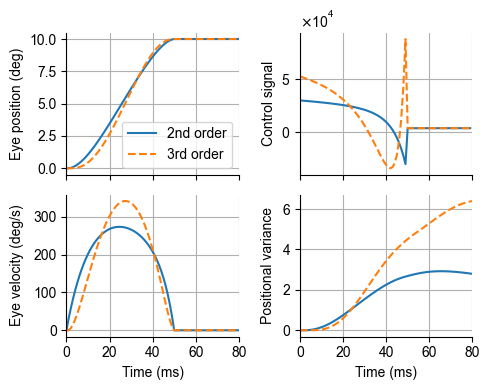

In [6]:
fig, axes = subplots(2, 2, figsize=(5, 4), sharex=true)
axf = axes[:]
ylabels = ["Eye position (deg)", "Eye velocity (deg/s)", "Control signal", "Positional variance"]
axf[1].plot(trange, x₂[1, :], label="2nd order"); 
axf[1].plot(trange, x₃[1, :], "--", label="3rd order"); 
axf[1].legend()

axf[2].plot(trange, x₂[2, :])
axf[2].plot(trange, x₃[2, :], "--"); 

axf[3].plot(trange[1:end-1], u₂)
axf[3].plot(trange[1:end-1], u₃, "--");
axf[3][:ticklabel_format](style="sci",axis="y", useMathText=true, scilimits=(0,0))

axf[4].plot(trange, Σ₂[1,1,:]); 
axf[4].plot(trange, Σ₃[1,1,:], "--");
for i in 1:4
    axf[i].set_ylabel(ylabels[i])
    axf[i].set_xlim(trange[1], trange[end])
    axf[i].grid()
    if i % 2 == 0
        axf[i].set_xlabel("Time (ms)");
    end
end
fig.align_ylabels()
fig.tight_layout()

目標位置と運動時間を変化させて速度の時系列の形状がどう変化するか確認しよう．ここでは

In [7]:
xf_pos = [5, 10, 20, 30, 40, 50]
Ts = [40, 50, 75, 100, 125, 150] * 1e-3
n_conds = length(xf_pos)

X = []
for i in 1:n_conds
    xf = [xf_pos[i], 0, 0]
    x, _, _ = minimum_variance_model(Ac₃, Bc₃, x0₃, xf, Ts[i], Tp, dt);
    push!(X, x)
end

3×3 Matrix{Float64}:
      0.0      1.0      0.0
      0.0      0.0      1.0
 -34340.7  -8482.14  -181.387

In [10]:
n = 3
A = I(n) + Ac₃ * dt

3×3 Matrix{Float64}:
   1.0      0.001    0.0
   0.0      1.0      0.001
 -34.3407  -8.48214  0.818613

線上の数字は目標位置を意味する．目標位置と運動時間を同時に変化させているため，この結果からは明らかではないが，運動時間が延びるほど速度推移は対称的な釣鐘型から非対称な形状に変化することが分かる．運動時間を変えない場合 (`Ts[i]` を `T` に置き換える場合) は目標位置に関わらず釣鐘型となる．目標位置を変えない場合 (`xf` を `xf₃` に置き換える場合)，速度の推移は同様に非対称な形状となる．

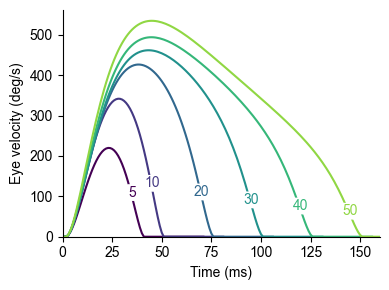

In [9]:
figure(figsize=(4,3))
cm = get_cmap(:viridis)
for i in 1:n_conds
    v = X[i][2, :]
    color = cm((i-1)/n_conds)
    plot((1:length(v)), v, color=color)
    label_x = round(Int, Ts[i]*1e3 - 5)
    text(label_x, v[label_x], string(xf_pos[i]), color=color, 
         ha="center", bbox=Dict(:boxstyle=>"round,pad=0.1",:ec=>"none", :fc=>"white"))
end
xlim(0, 160); ylim(0, )
xlabel("Time (ms)"); ylabel("Eye velocity (deg/s)")
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```